In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/commit_test_folder/EECE491-01-Capstone-Design')

Mounted at /content/drive


In [ ]:
# This cell prepares the Colab environment by copying and
# extracting the dataset from Google Drive to the fast local SSD.

import os
import time

# --- Part 1: Colab Local Data Setup ---
print("Starting data setup...")
start_setup_time = time.time()

# --- Define paths ---
DRIVE_ARCHIVE_PATH = "/content/drive/MyDrive/datasets/cropped_celeba.tar"
LOCAL_ARCHIVE_PATH = "/content/cropped_celeba.tar"
EXTRACT_PATH = "/content/celeba_dataset"

# The final, correct path to the images, based on our investigation
LOCAL_DATA_DIR = os.path.join(EXTRACT_PATH, "content", "cropped_celeba")

# --- Logic ---
# Only copy/untar if the local data directory doesn't already exist
if not os.path.exists(LOCAL_DATA_DIR):
    print(f"Copying {DRIVE_ARCHIVE_PATH} to local runtime...")
    if not os.path.exists(DRIVE_ARCHIVE_PATH):
        print(f"[FATAL ERROR] Source file not found: {DRIVE_ARCHIVE_PATH}")
        raise FileNotFoundError(f"Source file not found: {DRIVE_ARCHIVE_PATH}")

    # 1. Copy the single .tar file from Drive (fast)
    !cp "{DRIVE_ARCHIVE_PATH}" "{LOCAL_ARCHIVE_PATH}"
    print("Copy complete.")

    # 2. Extract the archive to the local SSD (fast)
    print(f"Untarring {LOCAL_ARCHIVE_PATH} to {EXTRACT_PATH}...")
    !mkdir -p "{EXTRACT_PATH}"
    !tar -xf "{LOCAL_ARCHIVE_PATH}" -C "{EXTRACT_PATH}"
    print("Untar complete.")

    # 3. Clean up the local archive to save space
    !rm "{LOCAL_ARCHIVE_PATH}"
else:
    print(f"Data directory {LOCAL_DATA_DIR} already exists. Skipping copy/untar.")

print(f"Data setup finished in {time.time() - start_setup_time:.2f} seconds.")

# --- Sanity Check ---
# Crucial check to ensure data exists before proceeding
if not os.path.exists(LOCAL_DATA_DIR):
    print(f"\n[FATAL ERROR] The expected data directory does not exist: {LOCAL_DATA_DIR}")
    raise FileNotFoundError(f"Could not find data at {LOCAL_DATA_DIR}")
else:
    print(f"Successfully found data at: {LOCAL_DATA_DIR}")

Starting data setup...
Copying /content/drive/MyDrive/datasets/cropped_celeba.tar to local runtime...
Copy complete.
Untarring /content/cropped_celeba.tar to /content/celeba_dataset...
Untar complete.
Data setup finished in 22.27 seconds.
Successfully found data at: /content/celeba_dataset/content/cropped_celeba


In [ ]:
import torch
# Import the function from the data_utils.py file we created
from data_utils import get_dataloaders

# --- Configuration ---
# Use the local data path defined in Cell 1
DATA_ROOT = LOCAL_DATA_DIR
BATCH_SIZE = 256
IMAGE_SIZE = 128
RANDOM_SEED = 42

# --- 1. Get Dataloaders ---
# This single function call does all the work
train_loader, val_loader, test_loader = get_dataloaders(
    root_dir=DATA_ROOT,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    random_seed=RANDOM_SEED
)

# --- 2. Verification ---
# Final check to ensure the dataloader works
if train_loader:
    print("\nVerifying one batch from train_loader...")
    try:
        # Get one sample batch
        images, labels = next(iter(train_loader))
        print(f"  Batch loaded successfully.")
        print(f"  Image batch shape: {images.shape}")
        print("\nSetup complete. You are ready to start training.")
    except Exception as e:
        print(f"  [Error] Failed to load batch: {e}")
else:
    print("\nData loading failed. Please check previous cell output.")


Loading dataset from: /content/celeba_dataset/content/cropped_celeba
Searching for '*.jpg' files in: /content/celeba_dataset/content/cropped_celeba
Successfully found 199509 images.
Successfully loaded 199509 total images.
Splitting dataset into:
  Train: 159607 images
  Validation: 19950 images
  Test: 19952 images

DataLoaders created successfully.

Verifying one batch from train_loader...
  Batch loaded successfully.
  Image batch shape: torch.Size([256, 3, 128, 128])

Setup complete. You are ready to start training.


In [ ]:
# (This is the main training/saving cell, modified for L1 + SSIM Loss)

# 👈 1. SSIM 라이브러리 설치 (최초 1회 실행)
!pip install piqa

import torch
import torch.nn as nn
import torch.optim as optim
import random
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from piqa.ssim import SSIM # 👈 2. SSIM 임포트

# --- 1. Import Modules ---
from channels import awgn_channel
from face_autoencoder import FaceAutoencoder

# (We assume train_loader and val_loader are loaded from the previous cell)
# (We assume the 'v2' Upsample + Conv2d face_autoencoder.py is being used)

# -----------------------------------------------
# 2. Training Setup
# -----------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = FaceAutoencoder(latent_dim=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 👈 3. (MODIFIED) L1 Loss와 SSIM Loss를 둘 다 정의
criterion_pixel = nn.L1Loss().to(device) # 1. 픽셀 손실 (L1)
criterion_ssim = SSIM(n_channels=3).to(device)   # 2. 구조 손실 (SSIM)

# 👈 4. (MODIFIED) 두 Loss의 가중치 설정
# L1을 기본으로 하고 SSIM을 보조로 사용합니다. (이 값은 튜닝이 필요할 수 있습니다)
LAMBDA_L1 = 1.0
LAMBDA_SSIM = 0.1 # (L1의 10% 정도의 가중치를 SSIM에 부여)

# (Training parameters)
num_epochs = 50
MIN_SNR_DB = 0.0
MAX_SNR_DB = 20.0

# (Save paths)
SAVE_DIR = "/content/drive/MyDrive/models"
# 👈 5. (MODIFIED) 새 모델 파일명
MODEL_PATH = os.path.join(SAVE_DIR, "face_autoencoder_512_L1_SSIM.pth")
os.makedirs(SAVE_DIR, exist_ok=True)

best_val_loss = float('inf')
train_loss_history = []
val_loss_history = []

# -----------------------------------------------
# 3. Training Loop (with Validation)
# -----------------------------------------------
print("Starting robust training (L1 Loss + SSIM Loss)...")
SNR_POINTS_FOR_VAL = [0.0, 5.0, 10.0, 15.0, 20.0]
NUM_VAL_POINTS = len(SNR_POINTS_FOR_VAL)

for epoch in range(num_epochs):

    # --- (A) Training Phase ---
    model.train()
    total_train_loss = 0

    for images, _ in train_loader:
        images = images.to(device)
        latent_vector = model.encode(images)
        current_snr_db = random.uniform(MIN_SNR_DB, MAX_SNR_DB)
        noisy_vector = awgn_channel(latent_vector, snr_db=current_snr_db)
        reconstructed_images = model.decode(noisy_vector)

        # 👈 6. (MODIFIED) SSIM 계산 전에 [0, 1] 리스케일링
        recon_rescaled = (reconstructed_images + 1.0) / 2.0
        images_rescaled = (images + 1.0) / 2.0

        # 👈 7. (MODIFIED) 결합 손실 계산
        loss_l1 = criterion_pixel(reconstructed_images, images) # L1은 [-1, 1] 원본으로 계산
        loss_ssim_val = criterion_ssim(recon_rescaled, images_rescaled)
        loss_ssim = 1.0 - loss_ssim_val # (1 - SSIM)

        loss = (LAMBDA_L1 * loss_l1) + (LAMBDA_SSIM * loss_ssim)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    # --- (B) Validation Phase ---
    model.eval()
    total_combined_loss = 0
    with torch.no_grad():
        for val_images, _ in val_loader:
            val_images = val_images.to(device)
            for fixed_snr_db in SNR_POINTS_FOR_VAL:
                latent_vector = model.encode(val_images)
                noisy_vector = awgn_channel(latent_vector, snr_db=fixed_snr_db)
                reconstructed_images = model.decode(noisy_vector)

                # 👈 6. (MODIFIED) SSIM 계산 전에 [0, 1] 리스케일링
                val_recon_rescaled = (reconstructed_images + 1.0) / 2.0
                val_images_rescaled = (val_images + 1.0) / 2.0

                # 👈 7. (MODIFIED) 결합 손실 계산
                val_loss_l1 = criterion_pixel(reconstructed_images, val_images)
                val_ssim_val = criterion_ssim(val_recon_rescaled, val_images_rescaled)
                val_loss_ssim = 1.0 - val_ssim_val

                val_loss = (LAMBDA_L1 * val_loss_l1) + (LAMBDA_SSIM * val_loss_ssim)
                total_combined_loss += val_loss.item()

    avg_val_loss = total_combined_loss / (len(val_loader) * NUM_VAL_POINTS)

    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)

    # --- (C) Log and Save Best Model ---
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print(f" -> New best validation loss! Saving model to {MODEL_PATH}")
        torch.save(model.state_dict(), MODEL_PATH)

print("--- Training finished. ---")
print(f"Best validation loss achieved: {best_val_loss:.6f}")
print(f"Best model saved to {MODEL_PATH}")



Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


Starting robust training (L1 Loss + SSIM Loss)...
Epoch [1/50], Train Loss: 0.285241, Val Loss: 0.182847
 -> New best validation loss! Saving model to /content/drive/MyDrive/models/face_autoencoder_512_L1_SSIM.pth
Epoch [2/50], Train Loss: 0.172396, Val Loss: 0.160257
 -> New best validation loss! Saving model to /content/drive/MyDrive/models/face_autoencoder_512_L1_SSIM.pth
Epoch [3/50], Train Loss: 0.154772, Val Loss: 0.154694
 -> New best validation loss! Saving model to /content/drive/MyDrive/models/face_autoencoder_512_L1_SSIM.pth
Epoch [4/50], Train Loss: 0.139845, Val Loss: 0.134705
 -> New best validation loss! Saving model to /content/drive/MyDrive/models/face_autoencoder_512_L1_SSIM.pth
Epoch [5/50], Train Loss: 0.129078, Val Loss: 0.128072
 -> New best validation loss! Saving model to /content/drive/MyDrive/models/face_autoencoder_512_L1_SSIM.pth
Epoch [6/50], Train Loss: 0.124209, Val Loss: 0.131372
Epoch [7/50], Train Loss: 0.120348, Val Loss: 0.126730
 -> New best validat

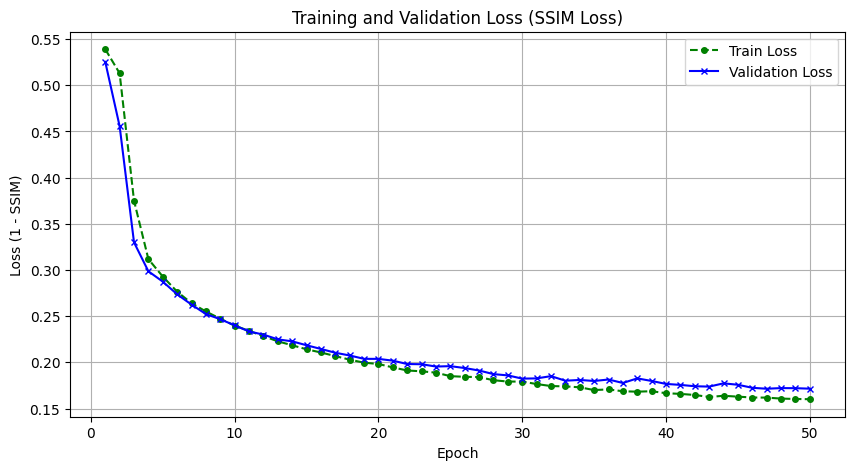

In [ ]:
# -----------------------------------------------
# 4. 훈련 완료 후 Loss 그래프 출력
# -----------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss',
         linestyle='--', color='green', marker='o', markersize=4)
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss',
         linestyle='-', color='blue', marker='x', markersize=4)
plt.xlabel('Epoch')
plt.ylabel('Loss (Combined L1 + SSIM)')
plt.title(r'Training and Validation Loss (L1:1.0, SSIM:0.1)') # 👈 타이틀 수정
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_locator(MultipleLocator(0.05))
plt.show()